## References

* HAT-P-44 b [(Fukui+16a)](http://iopscience.iop.org/article/10.3847/0004-637X/819/1/27/pdf)
* K2-3d [(Fukui+16b)](http://iopscience.iop.org/article/10.3847/0004-6256/152/6/171) 
* [HAT-P-44 b ref](http://exoplanet.eu/catalog/HAT-P-44_b/)
* [limb-darkening measurement](https://www.aanda.org/articles/aa/pdf/2013/12/aa22079-13.pdf)
* [stellar limb darkening and exoplanetary transits (Howarth 2011)](https://arxiv.org/pdf/1106.4659.pdf)

In [1]:
!python --version

Python 2.7.13 :: Continuum Analytics, Inc.


In [2]:
import os
os.environ['CONDA_DEFAULT_ENV']

'moscatel'

```
(1) File name of the light curves 

  Each file is named by the following format:

  lc[type(f or m)]_[instrument]_[band]_[target name]_[date]_t[target star ID]_c[comparison star IDs]_r[range of aperture radii].bjd.dat

  e.g., 
    lcf_msct_g_hatp12_170124_t1_c23_r28-36.bjd.dat

    meanings:
      type: f 
            (f: flux scale, m: magnitude scale)
      instrument: msct
      band: g
      target name: hatp12
      date: 170124
      target star ID: 1
      comparison star IDs: 2 & 3
      range of aperture radii: 28--36 (pix)

  * ".bjd." means that all time stamps were converted into BJD(TDB).


(2) Format of type "f" (flux scale) light curves 

  column1: Time (BJD_TDB-2450000)
  column2: Airmass
  column3: Mean sky background for all stars (ADU/pix)
  column4: Relative stellar displacement in X direction (pixel)
  column5: Relative stellar displacement in Y direction (pixel)
  column6: Mean FWHM of stellar PSFs (pixel)
  column7: Peak count of the brightest star (ADU)
  column8: Frame name
  column(9+i*2): Relative, normalized (so that the median is equal to unity), and un-detrended flux for the given aperture radius 
  column(9+i*2+1): Theoretical 1-sigma uncertainty of the relative flux for the given aperture radius (including photon noises of the stars, sky background noises, scintillation noises, readout noises, and dark noises) 


(3) Format of type "m" (magnitude scale) light curves
  
  column1: Time (BJD_TDB-2450000)
  column2: Airmass
  column3: Mean sky background for all stars ( mag = -2.5*log(sky(ADU)) )
  column4: Relative stellar displacement in X direction (pixel)
  column5: Relative stellar displacement in Y direction (pixel)
  column6: Mean FWHM of stellar PSFs (pixel)
  column7: Peak count of the brightest star ( mag = -2.5*log(peak(ADU)) )
  column8: Frame name
  column(9+i*3): raw magnitude of the target star for the given aperture radius, calculated by mag_t = -2.5*log(raw flux(ADU)) 
  column(9+i*3+1): raw magnitude of the ensemble of comparison stars for the given aperture radius, calculated by mag_c = -2.5*log(raw flux(ADU)) 
  column(9+i*3+2): Theoretical 1-sigma uncertainty of the magnitude difference between the target and compariosn stars for the given aperture radius, calculated by mag_t-c_err = sqrt(mag_t_err^2 + mag_c_err^2)
 
  The "raw magnitude" light curve can be used to partly correct the second-order extinction effect by fiting the coefficient of mag_c (without using approximated airmass values), which gives at least as well as, and in most cases better than, the conventional airmass correction to a relative, already-devided light curve. See Equation (8) of Fukui et al. 2016b:
    http://adsabs.harvard.edu/abs/2016AJ....152..171F

  This method is encouraged to be used as it is more physically motivated than the conventional airmass correction.
```

## import and parse csv

In [3]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#import multiprocessing

In [4]:
import getpass
from tqdm import tqdm

data_dir = '/home/'+getpass.getuser()+'/data/transit/hatp44_data/lc_hatp44_msct_170215'
file_list=glob.glob(data_dir+'/*.dat')
file_list.sort()

In [5]:
file_list

['/home/jp/data/transit/hatp44_data/lc_hatp44_msct_170215/lcf_msct_g_hatp44_170215_t2_c13_r9-14.bjd.dat',
 '/home/jp/data/transit/hatp44_data/lc_hatp44_msct_170215/lcf_msct_g_hatp44_170215_t2_c1_r9-14.bjd.dat',
 '/home/jp/data/transit/hatp44_data/lc_hatp44_msct_170215/lcf_msct_g_hatp44_170215_t2_c3_r9-14.bjd.dat',
 '/home/jp/data/transit/hatp44_data/lc_hatp44_msct_170215/lcf_msct_r_hatp44_170215_t2_c13_r9-14.bjd.dat',
 '/home/jp/data/transit/hatp44_data/lc_hatp44_msct_170215/lcf_msct_r_hatp44_170215_t2_c1_r9-14.bjd.dat',
 '/home/jp/data/transit/hatp44_data/lc_hatp44_msct_170215/lcf_msct_r_hatp44_170215_t2_c3_r9-14.bjd.dat',
 '/home/jp/data/transit/hatp44_data/lc_hatp44_msct_170215/lcf_msct_z_hatp44_170215_t2_c13_r9-14.bjd.dat',
 '/home/jp/data/transit/hatp44_data/lc_hatp44_msct_170215/lcf_msct_z_hatp44_170215_t2_c1_r9-14.bjd.dat',
 '/home/jp/data/transit/hatp44_data/lc_hatp44_msct_170215/lcf_msct_z_hatp44_170215_t2_c3_r9-14.bjd.dat',
 '/home/jp/data/transit/hatp44_data/lc_hatp44_msct_1

## import lc

In [6]:
name='hatp44'
date='170215'
target_star_id='2'
comparison_star_id='1'#13, #3
radii_range='9-14'

DF={}
bands='g,r,z'.split(',')
for b in bands:
    fname='lcf_msct_'+b+'_'+name+'_'+date+'_t'+target_star_id+'_c'+comparison_star_id+'_r'+radii_range+'.bjd.dat'
    df=pd.read_csv(os.path.join(data_dir,fname), delimiter=' ', parse_dates=True)
    df = df.set_index('BJD(TDB)-2450000')
    try:
        df=df.drop('Unnamed: 20',1)
    except:
        pass
    #df.head()
    DF[b]=df
    
DF['z'].head()

,airmass,sky(ADU),dx(pix),dy(pix),fwhm(pix),peak(ADU),frame,flux(r=9.0),err(r=9.0),flux(r=10.0),err(r=10.0),flux(r=11.0),err(r=11.0),flux(r=12.0),err(r=12.0),flux(r=13.0),err(r=13.0),flux(r=14.0),err(r=14.0)
BJD(TDB)-2450000,,,,,,,,,,,,,,,,,,,
7800.099704,1.9195,770.0,1.571,1.098,9.23,8484.4,MSCL2_1702150416,1.006060,0.002415,1.004150,0.002430,1.002697,0.002462,1.001681,0.002506,1.001059,0.002561,1.000910,0.002623
7800.100445,1.9101,760.9,1.183,1.363,8.84,8832.8,MSCL2_1702150417,1.003645,0.002405,1.003763,0.002425,1.004157,0.002461,1.003590,0.002507,1.004013,0.002564,1.002980,0.002624
7800.101185,1.9007,759.6,2.001,0.490,8.45,9166.4,MSCL2_1702150418,1.011944,0.002418,1.010547,0.002436,1.009671,0.002471,1.008578,0.002515,1.007796,0.002569,1.007015,0.002631
7800.101926,1.8915,758.3,2.197,1.278,8.64,9004.7,MSCL2_1702150419,1.000177,0.002418,0.999711,0.002433,0.999450,0.002466,0.998745,0.002509,0.999686,0.002565,0.999818,0.002626
7800.102655,1.8826,754.0,1.232,1.128,8.03,9894.7,MSCL2_1702150420,1.008416,0.002377,1.008160,0.002401,1.008227,0.002440,1.008178,0.002490,1.007604,0.002546,1.007852,0.002610


## g-band

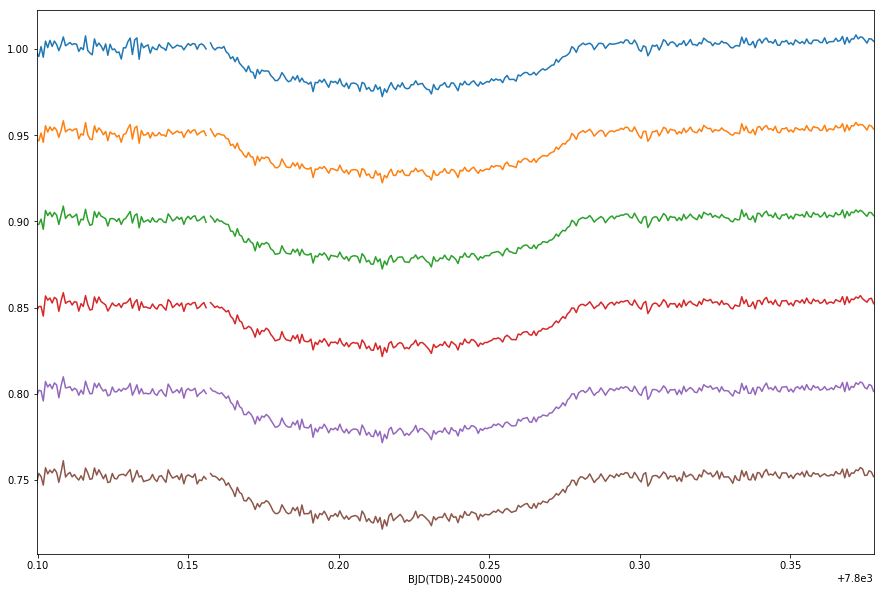

In [7]:
#fluxes
df=DF['g']
fluxes=df[df.columns[7:][::2]]
fluxes=fluxes[np.abs(fluxes-fluxes.mean())<=(3*fluxes.std())]
#add vertical offset
offset=0.05
for i,col in enumerate(fluxes.columns):
    fluxes[col].apply(lambda x : x-offset*i).plot(figsize=(15,10))

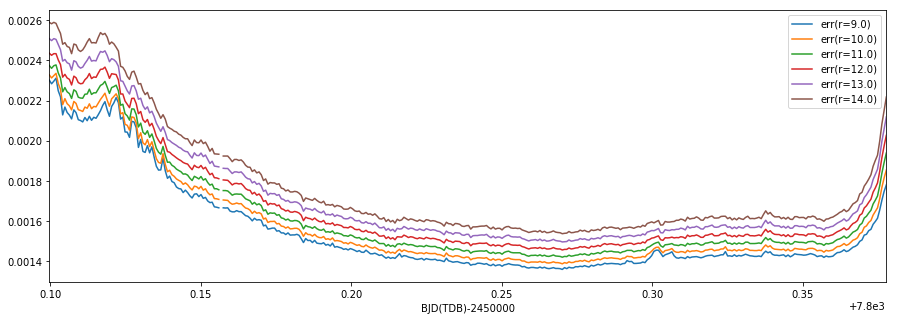

In [8]:
#errors
errors=df[df.columns[8:][::2]]
errors=errors[np.abs(errors-errors.mean())<=(3*errors.std())] 
errors.plot(figsize=(15,5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f57a7fdbad0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f57a7fa9550>], dtype=object)

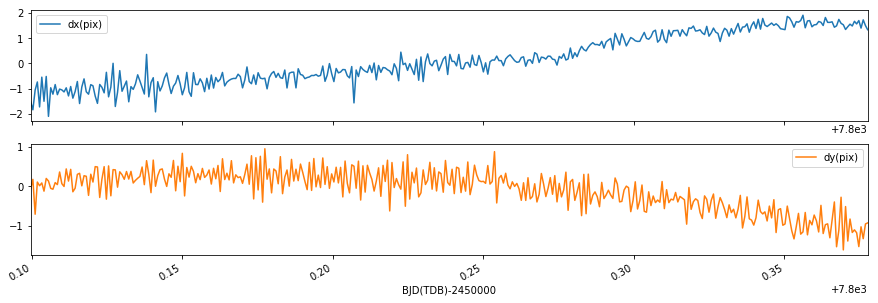

In [9]:
#centroids
cols='dx(pix),dy(pix)'.split(',')
df[cols].plot(figsize=(15,5),subplots=True)

## 3 bands one star

In [10]:
df.columns

Index([u'airmass', u'sky(ADU)', u'dx(pix)', u'dy(pix)', u'fwhm(pix)',
       u'peak(ADU)', u'frame', u'flux(r=9.0)', u'err(r=9.0)', u'flux(r=10.0)',
       u'err(r=10.0)', u'flux(r=11.0)', u'err(r=11.0)', u'flux(r=12.0)',
       u'err(r=12.0)', u'flux(r=13.0)', u'err(r=13.0)', u'flux(r=14.0)',
       u'err(r=14.0)'],
      dtype='object')

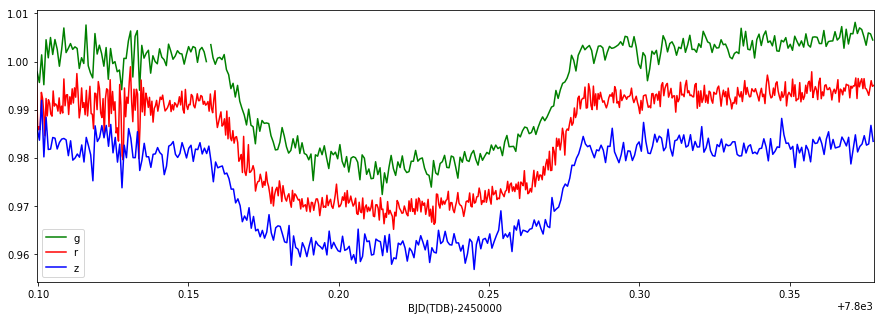

In [11]:
#add vertical offset
offset=0.01
col_id=df.columns[7] #flux(r=9.0)
colors='g,r,b'.split(',')
for i,(key,c) in enumerate(zip(sorted(DF.keys()),colors)):
    df=DF[key]
    fluxes=df[df.columns[7:][::2]]
    fluxes=fluxes[np.abs(fluxes-fluxes.mean())<=(3*fluxes.std())]
    fluxes[col_id].apply(lambda x : x-offset*i).plot(color=c,figsize=(15,5),label=key)
    #fluxes[col_id].plot(color=c,figsize=(15,5),label=key, marker='.', alpha=0.5)
plt.legend()

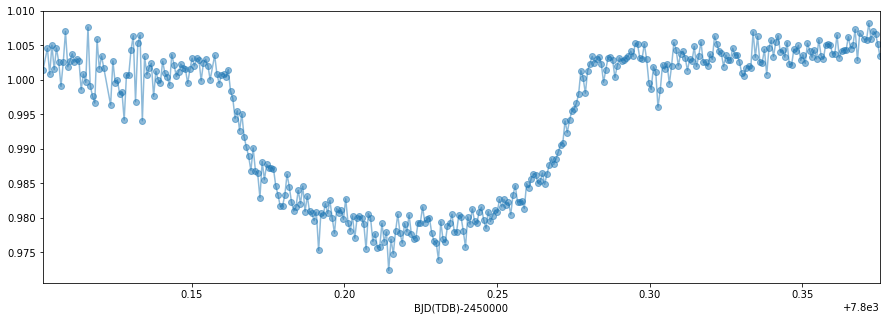

In [12]:
idx=6 #flux(r=9.0)
key='g'
df_z=DF[key]
#move frame column
df_z=df_z.drop('frame', axis=1)
#remove outliers
df_z=df_z[np.abs(df_z-df_z.mean())<=(3*df_z.std())]
#dropna
df_z=df_z.dropna(axis=0)

f=df_z[df_z.columns[idx]]
f.plot(figsize=(15,5), marker='o', alpha=0.5)

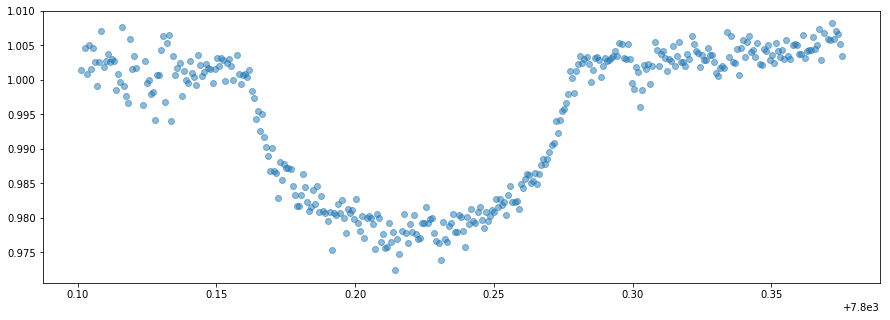

In [13]:
#clip the right side of baseline
clip=40
#df_z=df_z[:-clip]

t=df_z.index.values
f=df_z[df_z.columns[idx]].values

fig = plt.figure(figsize=(15,5))
plt.plot(t, f, 'o', alpha=0.5)

## building the model

Based on Hartman et al. [2014](http://iopscience.iop.org/article/10.1088/0004-6256/147/6/128/pdf)
* Teff: 5295±100
* P: 4.301219±0.000019
* Tc: 2455696.93695±0.00024
* T14: 0.1302±0.0008
* Rp/R*: 0.1343±0.0010
* c1, i: 0.3648
* c2, i: 0.2817

Lightcurve parameters
* i: 88.7+0.6-1.6
* Mp: 0.347±0.077
* Rp: 1.523+0.442-0.226
* rho_p: 0.12
* log g: 2.55±0.19
* a: 0.0509+0.0014−0.0008
* Teq: 1238+173-107

In [14]:
def scaled_a(p, t14, k, i=np.pi/2, b=0):
    numer = np.sqrt( (k + 1)**2 - b**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

In [15]:
#k,tc,a,inc,u1,u2
a_=0.0509
t14_ = 0.1302
k_ = 0.1343
tc_ = 2455696.93695
p_ = 4.301219
i_ =1.548107 #88.7 deg
u1_, u2_ = 0.4, 0.4

a_scaled_ = scaled_a(p_, t14_, k_, i_, b=0)
theta_true=[k_,tc_,a_scaled_, u1_, u2_]

In [16]:
tc = t.mean()
p = 4.3
k = np.sqrt(0.015)
inc = np.pi/2
t14 = 2.8/24
u1 = 0.4
u2 = 0.4
a = scaled_a(p, t14, k, i=np.pi/2)
# ls = np.log(f.std())
# k0 = 0
# theta = [k,tc,a,i,u1,u2,ls,k0]
theta = [k,tc,a,inc,u1,u2]
print ("initial guess: {}".format(theta))

initial guess: [0.1224744871391589, 7800.2391136311471, 13.18482235546915, 1.5707963267948966, 0.4, 0.4]


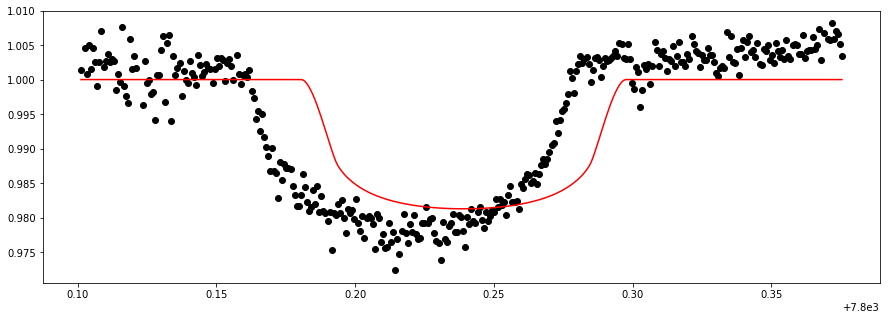

In [17]:
from pytransit import MandelAgol
MA = MandelAgol()

def model_u(theta, t, p):
    k,tc,a,i,u1,u2 = theta
    m = MA.evaluate(t, k, (u1, u2), tc, p, a, i)
    return m

fig = plt.figure(figsize=(15,5))
plt.plot(t, f, 'ko', t, model_u(theta, t, p), 'r-');

## MLE

* p, period
* k, r_planet/r_star
* t14, transit duration
* i, inclination
* b, impact paramter
* tc, mid-point transit time
* u1, u2, limb-darkening coeffs
* a_scaled

In [18]:
import scipy.optimize as op

def obj(theta, t, p, f):
    m = model_u(theta, t, p)
    return np.sum((m-f)**2)

print ("cost before: {}".format(obj(theta, t, p, f)))
res = op.minimize(obj, theta, args=(t, p, f), method='nelder-mead')

print ("cost after: {}".format(obj(res.x, t, p, f)))

cost before: 0.0159731818424
cost after: 0.00419201131138


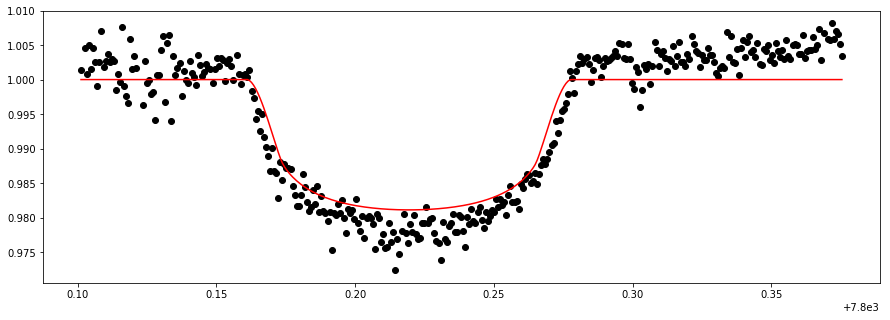

In [19]:
fig = plt.figure(figsize=(15,5))
plt.plot(t, f, 'ko', t, model_u(res.x, t, p), 'r-');

In [20]:
DF[key].columns

Index([u'airmass', u'sky(ADU)', u'dx(pix)', u'dy(pix)', u'fwhm(pix)',
       u'peak(ADU)', u'frame', u'flux(r=9.0)', u'err(r=9.0)', u'flux(r=10.0)',
       u'err(r=10.0)', u'flux(r=11.0)', u'err(r=11.0)', u'flux(r=12.0)',
       u'err(r=12.0)', u'flux(r=13.0)', u'err(r=13.0)', u'flux(r=14.0)',
       u'err(r=14.0)'],
      dtype='object')

In [21]:
#df_z=DF[key]

#excluded outliers
uncertainty=df_z['err(r=9.0)'].values#.dropna()
peak_flux=df_z['peak(ADU)'].values#.dropna()
fwhm = df_z['fwhm(pix)'].values#.dropna()
xcenter = df_z['dx(pix)'].values#.dropna()
ycenter = df_z['dy(pix)'].values#.dropna()

In [22]:
np.c_[fwhm, xcenter, ycenter].shape

(366, 3)

In [23]:
#systematics parameters
k0, k1, k2, k3, k4 = [0]*5
#log flux uncertainty
ls = np.log(np.nanstd(f))

#parameters vector: 6 free, 7 input
theta = [k,tc,a,inc,u1,u2,ls,k0,k1,k2,k3,k4]

#systematics model (time-dependent)
def model_s(theta, fwhm, uncertainty, xcenter, ycenter, t):
    #functional form of systematics model
    #dummy = np.ones(len(fwhm))
    s = (np.array(theta)*np.c_[fwhm, xcenter, ycenter, uncertainty, t]).sum(axis=1)
    # unpack 6 free params
    #a,b,c,d,e = theta
    #s = a + b*t + c*fwhm + d*xcenter + e*ycenter
    return s

def loglike(theta, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_mod=False, ret_sys=False, ret_full = False):
    ls = theta[6]
    m = model_u(theta[:6], t, p)
    s = model_s(theta[7:], fwhm, uncertainty, xcenter, ycenter, t) # #add sys model
    
    if ret_mod:
        return m
    if ret_sys:
        return s
    if ret_full:
        return m+s
    
    resid = f - m - s
    
    inv_sig2 = np.exp(-2*ls)
    
    return -0.5*(np.sum((resid)**2 * inv_sig2 + 2*ls))

#negative log-likelihood
nll = lambda *x: -loglike(*x)

print ("NLL before: {}".format(nll(theta, t, f, p, fwhm, uncertainty, xcenter, ycenter)))
result = op.minimize(nll, theta, args=(t, f, p, fwhm, uncertainty, xcenter, ycenter), method='nelder-mead')
print ("NLL after: {}".format(nll(result.x, t, f, p, fwhm, uncertainty, xcenter, ycenter)))

NLL before: -1592.05817288
NLL after: -1886.2977095


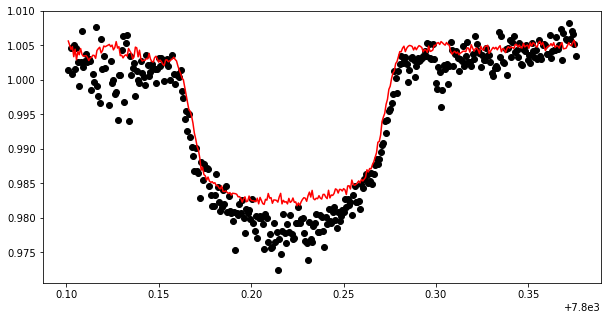

In [28]:
f_pred = loglike(result.x, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_full=True)
fig = plt.figure(figsize=(10,5))
plt.plot(t, f, 'ko', t, f_pred, 'r-')

## Maximum A Priori Estimation

In [32]:
def logprob(theta, t, f, p, fwhm, uncertainty, xcenter, ycenter, up=None):

    k,tc,a,i,u1,u2,ls,k0,k1,k2,k3,k4 = theta

    if u1 < 0 or u1 > 2 or u2 < -1 or u2 > 1 or k < 0 or k > 1 or i > np.pi/2:
        return -np.inf

    lp = 0
    #u prior
    if up is not None:
        lp += np.log(stats.norm.pdf(u1, loc=up[0], scale=up[1]))
        lp += np.log(stats.norm.pdf(u2, loc=up[2], scale=up[3]))

    ll = loglike(theta, t, f, p, fwhm, uncertainty, xcenter, ycenter)

    if np.isnan(ll).any():
        return -np.inf
    
    #total: sum of prior and likelihood
    return lp + ll

#negative log prob
nlp = lambda *x: -logprob(*x)

print ("NLP before: {}".format(nlp(theta, t, f, p, fwhm, uncertainty, xcenter, ycenter)))
res = op.minimize(nlp, theta, args=(t, p, f, fwhm, uncertainty, xcenter, ycenter), method='nelder-mead')
print ("NLP after: {}".format(nlp(res.x, t, f, p, fwhm, uncertainty, xcenter, ycenter)))

NLP before: -1592.05817288
NLP after: 3962910783.44


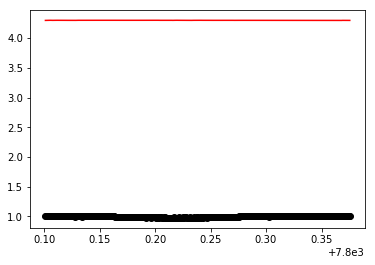

In [33]:
plt.plot(t, f, 'ko', t, loglike(res.x, t, f, p, fwhm, xcenter, uncertainty, ycenter, ret_full=True), 'r-')

## MCMC

Note the [difference](https://stats.stackexchange.com/questions/74082/what-is-the-difference-in-bayesian-estimate-and-maximum-likelihood-estimate) in interpretation of their results.

In [34]:
from emcee import MHSampler, EnsembleSampler
from emcee.utils import sample_ball
from tqdm import tqdm

ndim = len(theta)
nwalkers = 8 * ndim if ndim > 12 else 16 * ndim
nsteps1 = 1000

args = t, f, p, fwhm, uncertainty, xcenter, ycenter
sampler = EnsembleSampler(nwalkers, ndim, logprob,
    args=args, threads=1)

#random initial condition
pos0 = sample_ball(theta, [1e-4]*ndim, nwalkers)
'''pos0 = [np.array(initial) + 1e-8 * np.random.randn(ndim)
      for i in xrange(nwalkers)]'''

#begin
for pos,_,_ in tqdm(sampler.sample(pos0, iterations=nsteps1)):
    pass

0it [00:00, ?it/s]/home/jp/miniconda2/envs/moscatel/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/jp/miniconda2/envs/moscatel/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))
1000it [01:19, 12.64it/s]


## Parameter best estimates

In [35]:
param_names='k,tc,a,i,u1,u2,ls,k0,k1,k2,k3,k4'.split(',')

for n, i,j in zip(param_names, theta, sampler.flatchain.mean(axis=0)): 
    print('{0}: init={1}, post={2}'.format(n,i,j))

k: init=0.122474487139, post=0.133540853712
tc: init=7800.23911363, post=7800.22236448
a: init=13.1848223555, post=12.5497983579
i: init=1.57079632679, post=1.55996402686
u1: init=0.4, post=0.71662431607
u2: init=0.4, post=-0.0302566981101
ls: init=-4.54232499458, post=-5.64005337766
k0: init=0, post=-0.000823081068402
k1: init=0, post=0.000723319479616
k2: init=0, post=-0.000694938387159
k3: init=0, post=1.19302271326
k4: init=0, post=6.74606353751e-07


In [36]:
#nwalkers, nsteps, ndim
sampler.chain.shape

(192, 1000, 12)

In [37]:
#nwalkers*nsteps
sampler.flatlnprobability.shape

(192000,)

In [38]:
#nwalkers*nsteps, theta
sampler.flatchain.shape 

(192000, 12)

In [39]:
sampler.flatlnprobability.max()

2127.1286465192011

In [40]:
#sampler.flatchain.mean(axis=0)

max_idx=np.argmax(sampler.flatlnprobability)

#posterior of parameter vector
pv=sampler.flatchain[max_idx]
pv

array([  1.35778553e-01,   7.80021918e+03,   1.25444684e+01,
         1.56395704e+00,   1.04218028e+00,  -6.23607857e-01,
        -6.32636285e+00,  -1.58382195e-03,   9.00913537e-04,
        -3.81534548e-04,   3.32132321e+00,   1.09225075e-06])

## Initial results

In [41]:
chain = sampler.chain
len(chain.T)

12

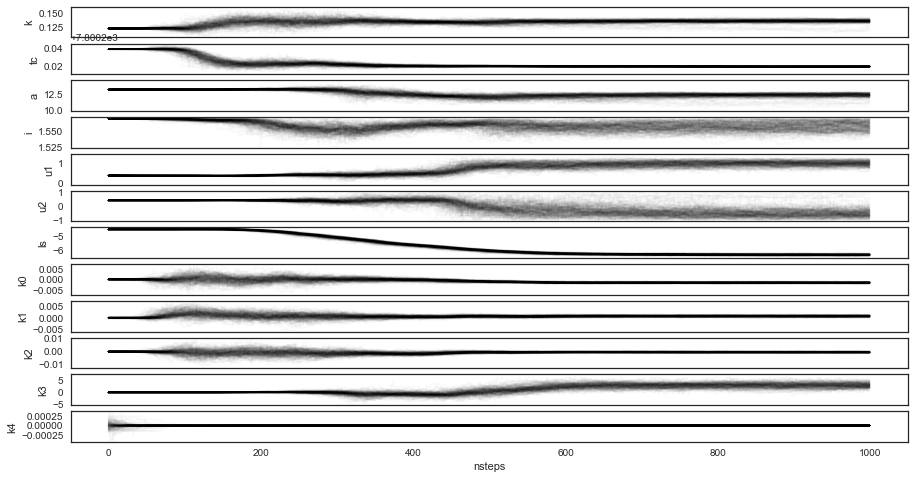

In [42]:
import seaborn as sb

with sb.axes_style('white'):
    nwalkers, nsteps, ndim = chain.shape
    fig, axs = plt.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
    [axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
    [axs.flat[i].set_ylabel(l) for i,l in enumerate(param_names)]
    
plt.xlabel('nsteps')

Monitor the [Gelman-Rubin statistic]() to ensure high quality posterior samples for the chains produced by the MCMC sampler 

* stabilize below a typical value of at most 1.03 up to a maximum of N steps for each of the N walkers
* cull the final chain using the burn-in value of N and thinning by a factor of 10 to account for autocorrelation in samples
* the final flattened chains thus consist of approximately X independent posterior samples

In [43]:
#nwalkers, nsteps, ndim
sampler.chain.shape

(192, 1000, 12)

In [44]:
burn = 500
#burn-in phase removed
sampler.chain[:,burn:,:].shape

(192, 500, 12)

## Reset sampler and re-run excluding burn-in phase

In [45]:
sampler.reset()
for pos,_,_ in tqdm(sampler.sample(pos, iterations=nsteps1)):
    pass

1000it [01:07, 14.87it/s]


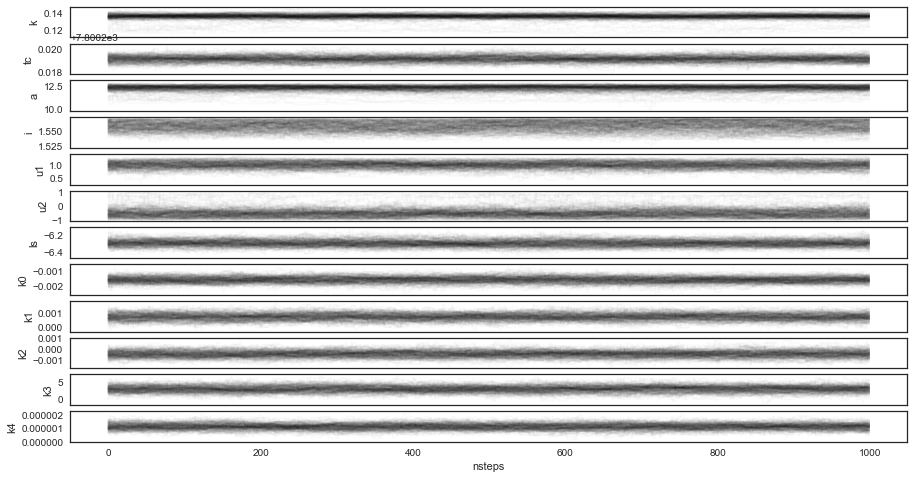

In [46]:
import seaborn as sb

chain = sampler.chain

with sb.axes_style('white'):
    nwalkers, nsteps, ndim = chain.shape
    fig, axs = plt.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
    [axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
    [axs.flat[i].set_ylabel(l) for i,l in enumerate(param_names)]
    
plt.xlabel('nsteps')

Doesn't look more stable than burn-in stage before just because of the y-scaling.

## Results

In [47]:
#using full chain excluding burn-in
max_idx=np.argmax(sampler.flatlnprobability)

#posterior of parameter vector
pv=sampler.flatchain[max_idx]
pv

array([  1.36422731e-01,   7.80021919e+03,   1.24395648e+01,
         1.55914213e+00,   1.08773959e+00,  -6.90399194e-01,
        -6.32821897e+00,  -1.62989979e-03,   7.40999286e-04,
        -4.53370298e-04,   2.90928173e+00,   1.22882215e-06])

In [48]:
#flat chain
fc=sampler.chain[:,burn:,:].reshape(-1, ndim)

In [49]:
fc.shape

(96000, 12)

In [50]:
fc.mean(axis=0)

array([  1.35880672e-01,   7.80021919e+03,   1.22814013e+01,
         1.55819420e+00,   9.99281330e-01,  -4.86413321e-01,
        -6.29778050e+00,  -1.56549646e-03,   7.48650681e-04,
        -4.88426937e-04,   3.01521773e+00,   1.14567722e-06])

In [51]:
#posteriors: draw 100 random from fc
mod_sys = [loglike(pv, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_full=True) for th in fc[np.random.randint(0, fc.shape[0], size=100)]]
sys = [loglike(pv, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_sys=True) for th in fc[np.random.randint(0, fc.shape[0], size=100)]]
mod = [loglike(pv, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_mod=True) for th in fc[np.random.randint(0, fc.shape[0], size=100)]]

### systematics only

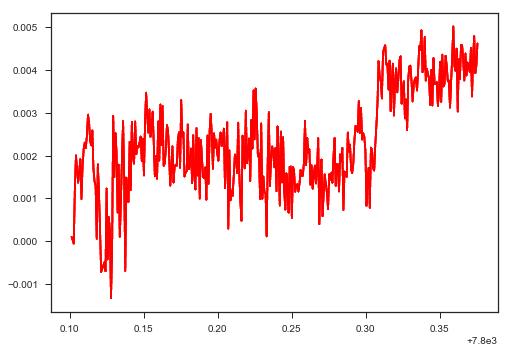

In [62]:
import seaborn as sb
with sb.axes_style('ticks'):
    for s in sys:
        plt.plot(t, s, 'r-', alpha=0.03)

In [57]:
len(sys)

100

In [60]:
len(sys[0])

366

### data - systematics

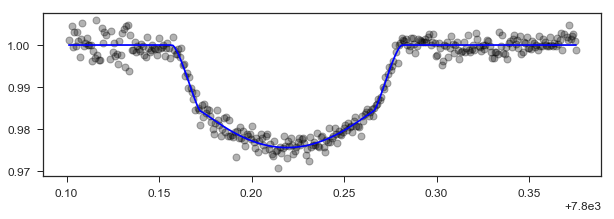

In [72]:
import seaborn as sb
n=0
with sb.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, figsize=(10,3))
    ax.plot(t, f-sys[n], linestyle='none', marker='o',
        color='k', alpha=0.3, mew=1, mec='k')
    ax.plot(t, mod[n], 'b-')

### model + systematics

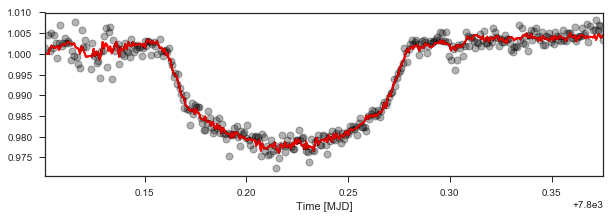

In [63]:
#posterior
ps = [loglike(pv, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_full=True) for th in fc[np.random.randint(0, fc.shape[0], size=100)]]

with sb.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, figsize=(10,3))
    ax.plot(t, f, linestyle='none', marker='o',
        color='k', alpha=0.3, mew=1, mec='k')
    for s in ps:
        ax.plot(t, s, 'r-', alpha=0.03)
    plt.setp(ax, xlabel='Time [MJD]', xlim=(t.min(), t.max()))

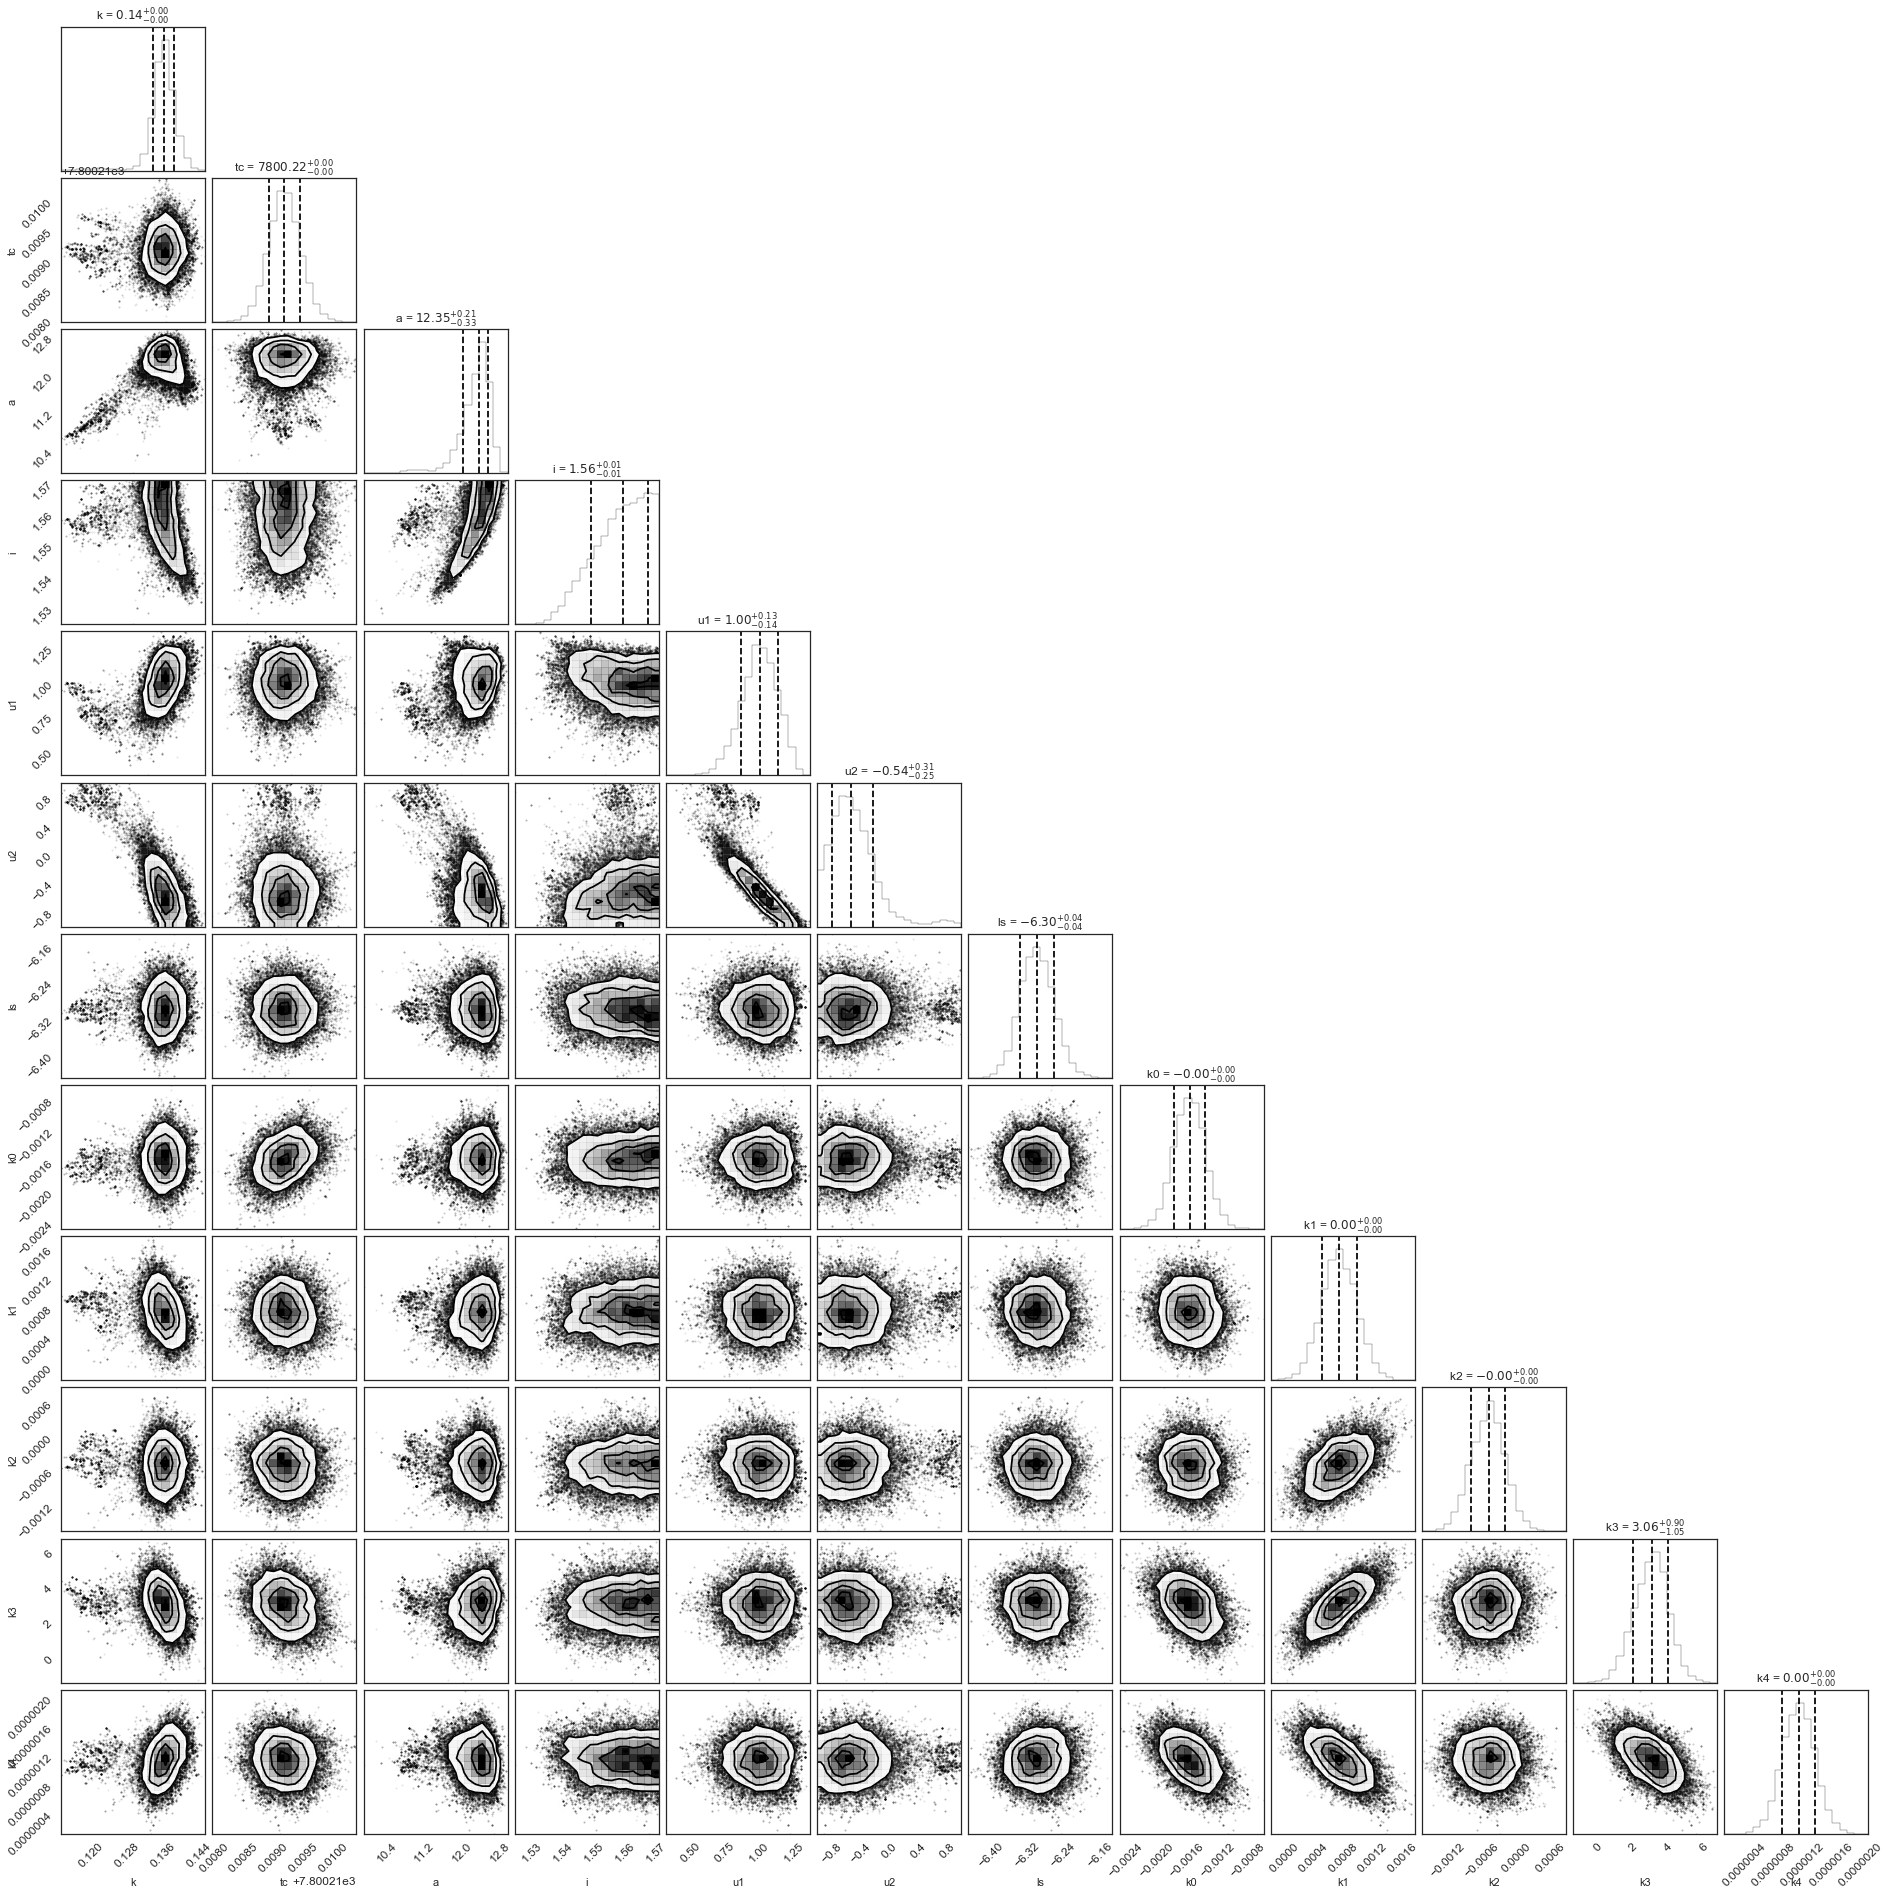

In [68]:
plt.rcParams['ytick.labelsize'] = 'medium'
plt.rcParams['xtick.labelsize'] = 'medium'

import corner

with sb.axes_style('white'):
    corner.corner(fc, labels=param_names, 
                  quantiles=[0.16, 0.5, 0.84], 
                  show_titles=True, title_kwargs={"fontsize": 12});

correlation: u1, u2; k1, k3; i, a

In [69]:
for n, i in zip(param_names, pv): 
    print('{0}: {1:.4f}'.format(n,i))

k: 0.1364
tc: 7800.2192
a: 12.4396
i: 1.5591
u1: 1.0877
u2: -0.6904
ls: -6.3282
k0: -0.0016
k1: 0.0007
k2: -0.0005
k3: 2.9093
k4: 0.0000


Compare the above results to previous [published results](http://exoplanet.eu/catalog/HAT-P-44_b/).

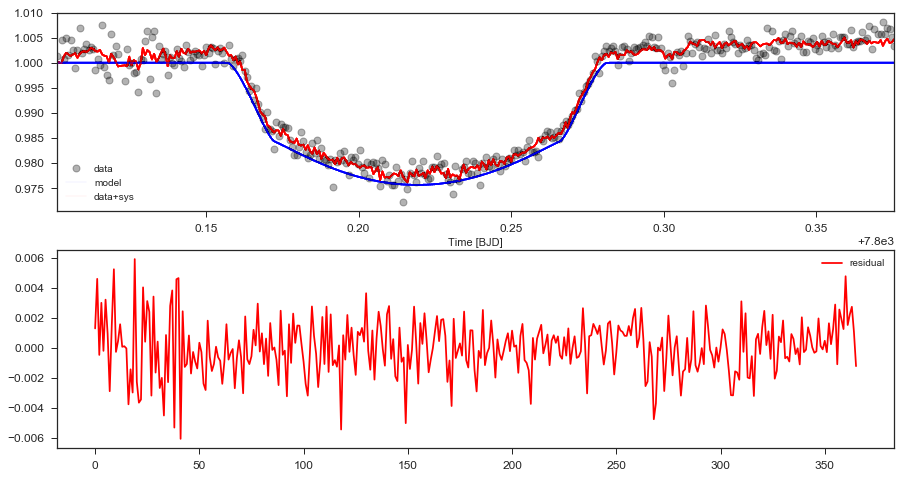

In [70]:
with sb.axes_style('ticks'):
    fig, ax = plt.subplots(2, 1, figsize=(15,8))
    #data
    ax[0].plot(t, f, linestyle='none', marker='o',
        color='k', alpha=0.3, mew=1, mec='k')
    for s in ps:
        #model
        ax[0].plot(t, loglike(pv, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_mod=True), 
                   'b-', alpha=0.03) 
        #model+systematics
        ax[0].plot(t, s, 'r-', alpha=0.03)
    #residual
    res = loglike(pv, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_full=True)
    ax[1].plot(f-res, 'r-', label='residual')
    plt.setp(ax[0], xlabel='Time [BJD]',
        xlim=(t.min(), t.max()))
ax[0].legend(['data','model','data+sys'], loc='lower left')
ax[1].legend(loc='best')

## comparison of results between MCMC and MLE

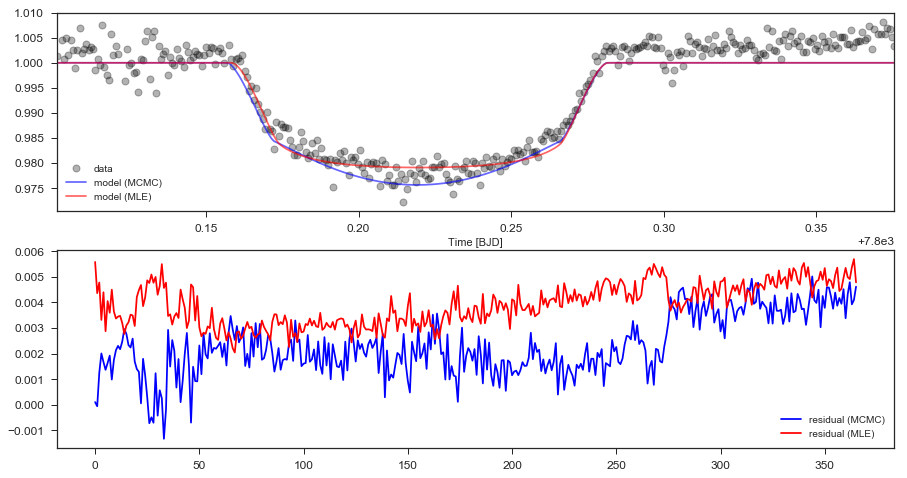

In [71]:
#result from ML
f_MLE_mod = loglike(result.x, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_mod=True)
f_MLE_full = loglike(result.x, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_full=True)
MLE_sys = loglike(result.x, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_sys=True)

f_MC_mod = loglike(pv, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_mod=True)
MC_sys = loglike(pv, t, f, p, fwhm, uncertainty, xcenter, ycenter, ret_sys=True)
    
with sb.axes_style('ticks'):
    fig, ax = plt.subplots(2, 1, figsize=(15,8))
    #data
    ax[0].plot(t, f, linestyle='none', marker='o',
        color='k', alpha=0.3, mew=1, mec='k')
    #models
    ax[0].plot(t, f_MC_mod, 'b-', alpha=0.6)
    ax[0].plot(t, f_MLE_mod, 'r-', alpha=0.6)
    #residuals
    ax[1].plot(MC_sys, 'b-', label='residual (MCMC)') #f_MC_mod-f_MC_full
    ax[1].plot(MLE_sys, 'r-', label='residual (MLE)') #f_MLE_mod-f_MLE_full
    
    plt.setp(ax[0], xlabel='Time [BJD]',xlim=(t.min(), t.max()))
    
ax[0].legend(['data','model (MCMC)', 'model (MLE)'], loc='lower left')
ax[1].legend(loc='best')

In [53]:
#posterior
#sampler.flatchain.mean(axis=0)
max_idx=np.argmax(sampler.flatlnprobability)
#posterior of parameter vector
pv=sampler.flatchain[max_idx]

for n, i,j in zip(param_names, result.x, pv): 
    print('{0}: diff={1:.4f}'.format(n,i-j))

k: diff=-0.0016
tc: diff=0.0009
a: diff=-0.0516
i: diff=0.0310
u1: diff=-0.8094
u2: diff=0.9716
ls: diff=0.8648
k0: diff=0.0026
k1: diff=-0.0002
k2: diff=-0.0001
k3: diff=-3.3588
k4: diff=-0.0000


Almost 0.2 AU difference in semi-major axis, -2 diff in k3 (xcenter?), etc.

/home/jp/miniconda2/envs/moscatel/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  after removing the cwd from sys.path.


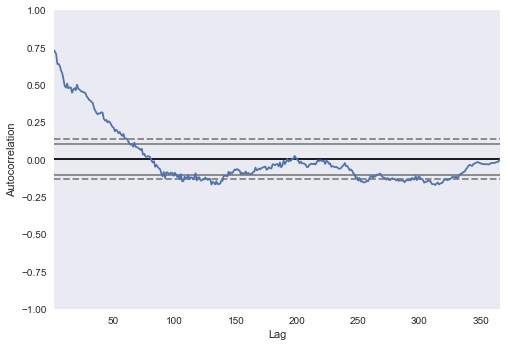

In [54]:
from pandas.tools.plotting import autocorrelation_plot

plt.figure()
autocorrelation_plot(MC_sys)

/home/jp/miniconda2/envs/moscatel/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  after removing the cwd from sys.path.


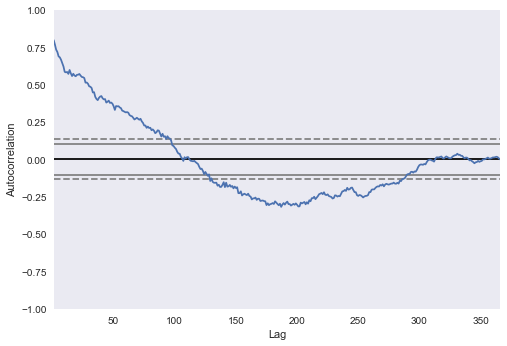

In [55]:
from pandas.tools.plotting import autocorrelation_plot

plt.figure()
autocorrelation_plot(MLE_sys)

## GP model

In [56]:
import george
george.__version__

'0.2.1'

In [57]:
from george.kernels import ExpSquaredKernel

# Set up the Gaussian process with exp sqrd kernel
kernel = ExpSquaredKernel(1.0)
gp = george.GP(kernel)

# Pre-compute the factorization of the matrix
gp.compute(t, ls)

# Compute the log likelihood
print(gp.lnlikelihood(f))

-892.236260935


In [58]:
# compare to MCMC result
sampler.flatlnprobability.max()

2127.0535836561708

In [59]:
# predict the mean (most probable) fit given data
mu, cov = gp.predict(f, t)
std = np.sqrt(np.diag(cov))

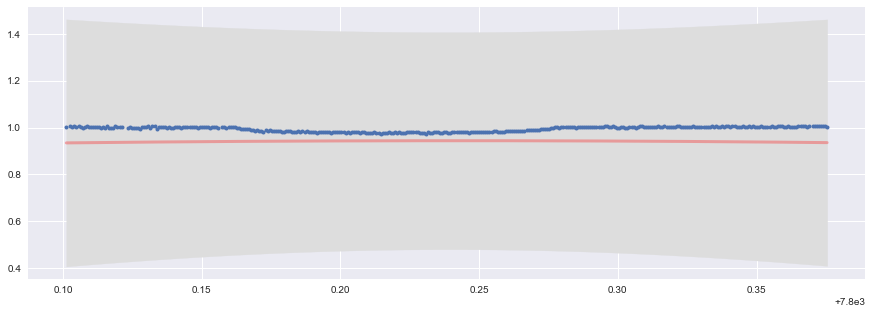

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(15,5))
# data
plt.plot(t, f, '.', ms=8)
# prediction
plt.plot(t, mu, 'r-', alpha=0.3, linewidth=3)
# confidence intervals
plt.gca().fill_between(t, mu-2*std, mu+2*std, color="#dddddd")

## To Do:

* optimize photometry for better g and r-band light curves
* fix lapses in fwhm estimation
* simplify systematics model